<a href="https://colab.research.google.com/github/smor/ZoeDepth/blob/main/Tiled_ZoeDepth%2C_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Depth Map Generation**

This is an adapted version of https://colab.research.google.com/github/isl-org/ZoeDepth/blob/main/notebooks/ZoeDepth_quickstart.ipynb

Corresponding paper : [ZoeDepth: Zero-shot Transfer by Combining Relative and Metric Depth](https://arxiv.org/abs/2302.12288v1)

Here, higher resolution depth maps are generated from the following process:

1.   Generate a depth map for the overall image
2.   Split original image into overlapping tiles
3.   Generate depth maps for the tiles
4.   Reassemble into a single depth map by applying gradient masks and average weighting from first depth map
5.   Repeat steps 2-4 at higher resolution
6.   Combine all three depth maps by:
  *   Calculate edge filter from original RGB image
  *   Blur edge filter and use as mask for high resolution depth map
  *   Apply masked high resolution to average of low and medium resolution depth maps

It is possible to use BYOD to replace step 6:
https://github.com/compphoto/BoostYourOwnDepth

However, it currently leads to banding due to 8-bit images being used instead of 16 bit:
https://github.com/compphoto/BoostingMonocularDepth/issues/62

<br>

My repository page for this project:
https://github.com/BillFSmith/TilingZoeDepth

/content


Saving demon_pokemon_basrelief.webp to demon_pokemon_basrelief.webp
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.0/510.0 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 79.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 65.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 67.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 90.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 MB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.6/102.6 MB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/torch/hub.py:286: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/intel-isl/MiDaS/zipball/master" to /root/.cache/torch/hub/master.zip
/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _V

Params passed to Resize transform:
	width:  512
	height:  384
	resize_target:  True
	keep_aspect_ratio:  True
	ensure_multiple_of:  32
	resize_method:  minimal
Using pretrained resource url::https://github.com/isl-org/ZoeDepth/releases/download/v1.0/ZoeD_M12_N.pt


Downloading: "https://github.com/isl-org/ZoeDepth/releases/download/v1.0/ZoeD_M12_N.pt" to /root/.cache/torch/hub/checkpoints/ZoeD_M12_N.pt
100%|██████████| 1.34G/1.34G [00:08<00:00, 179MB/s]


Loaded successfully
Processing Started


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Original low resolution result


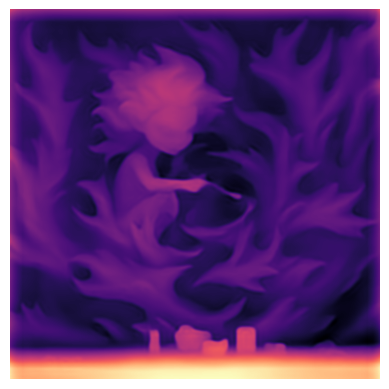


New high resolution result


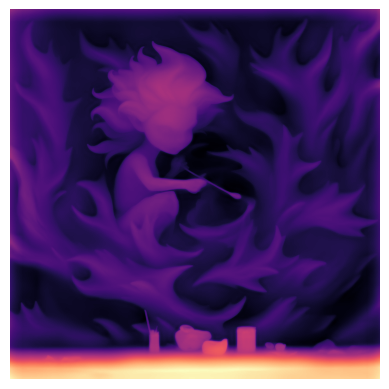

Processing ended


In [1]:
#@title Code (press Ctrl + F9 to run)

from google.colab import files
%cd '/content/'
uploaded = files.upload()

import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

import os, contextlib
with open(os.devnull, 'w') as devnull:
    with contextlib.redirect_stdout(devnull):
        import numpy as np
        import cv2

dependencies = {}

!pip install --upgrade timm==0.6.7 torch==2.0.1 torchvision==0.15.2 numpy==1.23.5 pillow==9.4.0

!git clone https://github.com/isl-org/ZoeDepth.git
%cd ZoeDepth
# !python sanity.py

import torch
from zoedepth.utils.misc import get_image_from_url, colorize
from PIL import Image
import matplotlib.pyplot as plt

zoe = torch.hub.load(".", "ZoeD_N", source="local", pretrained=True)

# zoe = zoe.to('cuda')
dependencies['zoe'] = zoe.to('cuda')

from PIL import Image
import matplotlib.pyplot as plt


for filename in list(uploaded.keys()):
    print('Processing Started')

    img = Image.open('/content/' + filename)

    # Generate low resolution image
    # low_res_depth = zoe.infer_pil(img)
    low_res_depth = dependencies['zoe'].infer_pil(img)
    low_res_scaled_depth = 2**16 - (low_res_depth - np.min(low_res_depth)) * 2**16 / (np.max(low_res_depth) - np.min(low_res_depth))

    low_res_depth_map_image = Image.fromarray((0.999 * low_res_scaled_depth).astype("uint16"))
    low_res_depth_map_image.save('zoe_depth_map_16bit_low.png')

    # Generate filters

    # store filters in lists
    im = np.asarray(img)

    tile_sizes = [[4,4], [8,8]]

    filters = []

    save_filter_images = True

    for tile_size in tile_sizes:

        num_x = tile_size[0]
        num_y = tile_size[1]

        M = im.shape[0]//num_x
        N = im.shape[1]//num_y

        filter_dict = {}
        filter_dict['right_filter'] = np.zeros((M, N))
        filter_dict['left_filter'] = np.zeros((M, N))
        filter_dict['top_filter'] = np.zeros((M, N))
        filter_dict['bottom_filter'] = np.zeros((M, N))
        filter_dict['top_right_filter'] = np.zeros((M, N))
        filter_dict['top_left_filter'] = np.zeros((M, N))
        filter_dict['bottom_right_filter'] = np.zeros((M, N))
        filter_dict['bottom_left_filter'] = np.zeros((M, N))
        filter_dict['filter'] = np.zeros((M, N))

        for i in range(M):
          for j in range(N):
              x_value = 0.998*np.cos((abs(M/2-i)/M)*np.pi)**2
              y_value = 0.998*np.cos((abs(N/2-j)/N)*np.pi)**2

              if j > N/2:
                  filter_dict['right_filter'][i,j] = x_value
              else:
                  filter_dict['right_filter'][i,j] = x_value * y_value

              if j < N/2:
                  filter_dict['left_filter'][i,j] = x_value
              else:
                  filter_dict['left_filter'][i,j] = x_value * y_value

              if i < M/2:
                  filter_dict['top_filter'][i,j] = y_value
              else:
                  filter_dict['top_filter'][i,j] = x_value * y_value

              if i > M/2:
                  filter_dict['bottom_filter'][i,j] = y_value
              else:
                  filter_dict['bottom_filter'][i,j] = x_value * y_value

              if j > N/2 and i < M/2:
                  filter_dict['top_right_filter'][i,j] = 0.998
              elif j > N/2:
                  filter_dict['top_right_filter'][i,j] = x_value
              elif i < M/2:
                  filter_dict['top_right_filter'][i,j] = y_value
              else:
                  filter_dict['top_right_filter'][i,j] = x_value * y_value

              if j < N/2 and i < M/2:
                  filter_dict['top_left_filter'][i,j] = 0.998
              elif j < N/2:
                  filter_dict['top_left_filter'][i,j] = x_value
              elif i < M/2:
                  filter_dict['top_left_filter'][i,j] = y_value
              else:
                  filter_dict['top_left_filter'][i,j] = x_value * y_value

              if j > N/2 and i > M/2:
                  filter_dict['bottom_right_filter'][i,j] = 0.998
              elif j > N/2:
                  filter_dict['bottom_right_filter'][i,j] = x_value
              elif i > M/2:
                  filter_dict['bottom_right_filter'][i,j] = y_value
              else:
                  filter_dict['bottom_right_filter'][i,j] = x_value * y_value

              if j < N/2 and i > M/2:
                  filter_dict['bottom_left_filter'][i,j] = 0.998
              elif j < N/2:
                  filter_dict['bottom_left_filter'][i,j] = x_value
              elif i > M/2:
                  filter_dict['bottom_left_filter'][i,j] = y_value
              else:
                  filter_dict['bottom_left_filter'][i,j] = x_value * y_value

              filter_dict['filter'][i,j] = x_value * y_value

        filters.append(filter_dict)

        if save_filter_images:
            for filter in list(filter_dict.keys()):
                filter_image = Image.fromarray((filter_dict[filter]*2**16).astype("uint16"))
                filter_image.save(f'mask_{filter}_{num_x}_{num_y}.png')


    # filters second section
    compiled_tiles_list = []

    for i in range(len(filters)):

        num_x = tile_sizes[i][0]
        num_y = tile_sizes[i][1]

        M = im.shape[0]//num_x
        N = im.shape[1]//num_y

        compiled_tiles = np.zeros((im.shape[0], im.shape[1]))

        x_coords = list(range(0,im.shape[0],im.shape[0]//num_x))[:num_x]
        y_coords = list(range(0,im.shape[1],im.shape[1]//num_y))[:num_y]

        x_coords_between = list(range((im.shape[0]//num_x)//2, im.shape[0], im.shape[0]//num_x))[:num_x-1]
        y_coords_between = list(range((im.shape[1]//num_y)//2,im.shape[1],im.shape[1]//num_y))[:num_y-1]

        x_coords_all = x_coords + x_coords_between
        y_coords_all = y_coords + y_coords_between

        for x in x_coords_all:
            for y in y_coords_all:

                # depth = zoe.infer_pil(Image.fromarray(np.uint8(im[x:x+M,y:y+N])))
                depth = dependencies['zoe'].infer_pil(Image.fromarray(np.uint8(im[x:x+M,y:y+N])))


                scaled_depth = 2**16 - (depth - np.min(depth)) * 2**16 / (np.max(depth) - np.min(depth))

                if y == min(y_coords_all) and x == min(x_coords_all):
                    selected_filter = filters[i]['top_left_filter']
                elif y == min(y_coords_all) and x == max(x_coords_all):
                    selected_filter = filters[i]['bottom_left_filter']
                elif y == max(y_coords_all) and x == min(x_coords_all):
                    selected_filter = filters[i]['top_right_filter']
                elif y == max(y_coords_all) and x == max(x_coords_all):
                    selected_filter = filters[i]['bottom_right_filter']
                elif y == min(y_coords_all):
                    selected_filter = filters[i]['left_filter']
                elif y == max(y_coords_all):
                    selected_filter = filters[i]['right_filter']
                elif x == min(x_coords_all):
                    selected_filter = filters[i]['top_filter']
                elif x == max(x_coords_all):
                    selected_filter = filters[i]['bottom_filter']
                else:
                    selected_filter = filters[i]['filter']

                compiled_tiles[x:x+M, y:y+N] += selected_filter * (np.mean(low_res_scaled_depth[x:x+M, y:y+N]) + np.std(low_res_scaled_depth[x:x+M, y:y+N]) * ((scaled_depth - np.mean(scaled_depth)) /  np.std(scaled_depth)))

        compiled_tiles[compiled_tiles < 0] = 0
        compiled_tiles_list.append(compiled_tiles)

        tiled_depth_map = Image.fromarray((2**16 * 0.999 * compiled_tiles / np.max(compiled_tiles)).astype("uint16"))
        tiled_depth_map.save(f'tiled_depth_{i}.png')

    # combine depth maps
    from scipy.ndimage import gaussian_filter

    grey_im = np.mean(im,axis=2)

    tiles_blur = gaussian_filter(grey_im, sigma=20)
    tiles_difference = tiles_blur - grey_im

    tiles_difference = tiles_difference / np.max(tiles_difference)

    tiles_difference = gaussian_filter(tiles_difference, sigma=40)

    tiles_difference *= 5

    tiles_difference = np.clip(tiles_difference, 0, 0.999)

    mask_image = Image.fromarray((tiles_difference*2**16).astype("uint16"))
    mask_image.save('mask_image.png')

    combined_result = (tiles_difference * compiled_tiles_list[1] + (1-tiles_difference) * ((compiled_tiles_list[0] + low_res_scaled_depth)/2))/(2)

    combined_image = Image.fromarray((2**16 * 0.999* combined_result / np.max(combined_result)).astype("uint16"))
    # combined_image.save('combined_image.png')
    combined_image.save(filename.split('.')[0] + '_depth.png')
    files.download(filename.split('.')[0] + '_depth.png')

    # display output images

    print('Original low resolution result')
    plt.imshow(low_res_scaled_depth, 'magma')
    plt.axis("off")
    plt.show()

    print('\nNew high resolution result')
    plt.imshow(combined_result, 'magma')
    plt.axis("off")
    plt.show()

    print("Processing ended")


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
